### Постановка задачи

1. Используя предобученную сеть ImageNet, дообучить её посредством Fine Turning и аугментации для решения поставленной задачи классификации автомобилей по изображению 

2. Для оценки качества модели будем использовать кривые обучения и валидации. 
Существует три основных динамики, отображаемых кривыми:
* Недообучение - кривая training loss остаётся ровной, независимо от ходя тренировки. Кривая training loss продолжает значительно убывать в конце тренировки сети
* Переобучение - кривая training loss продолжает убывать на протяжении всего обучения. Кривая validation loss убывает и снова возрастает.  
* Качественное обучение - график training loss стабильно убывает. График validation loss стабильно убывает и имеет пересечение с графиком training loss


In [4]:
# # Обновление tensorflow
# !pip install tensorflow --upgrade
# # Загрузка модели efficientnet
# !pip install -q efficientnet
# # Загружаем обвязку под keras для использования продвинутых библиотек аугментации, например, albuminations
# !pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [5]:
!pip freeze > requirements.txt

## 1. Импорт необходимых библиотек и основные настройки

In [6]:
# Importing modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as layers
import efficientnet.tfkeras as efn
import PIL
import albumentations
import pickle
import zipfile
import csv
import sys
import os
import shutil

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import EfficientNetB7
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from ImageDataAugmentor.image_data_augmentor import *
from PIL import ImageOps, ImageFilter
from pylab import rcParams
from keras import backend as K

rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input/sf-dl-car-classification"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']
Python       : 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


### Основные настройки

1. Количество "эпох", циклов обучения, в приметивном понимании влияет на качество прямо пропорционально и на скорость обучения обратнопропорционально. В процессе подбора оптимальных параметров колчество эпох меняется, в зависимости от результатов предыдущей итерации.

2. Размер батча определяет разбиение датасета на составные части для обучения. Общее число тренировочных объектов в одном батче.

3. Learnin Rate - коэффициент обучения. Определяет скорость обучения, влияет на процесс градиентного спуска. При увеличении есть вероятность "проскакивать" глобальный минимум, при маленьком значении можно ошибочно "застрять" в локальном минимуме

4. VAL_SPLIT - часть датасета выделяемая на тест

5. CLASS_NUM - количество классов, на которые разделены изображения

6. IMG_SIZE - размер изображения, подаваемого в сеть

7. IMG_CHANNELS - колчество каналов. Так как изображения цветные - количество канало равно 3.

In [15]:

EPOCHS               = 10  
BATCH_SIZE           = 32 
LR                   = 1e-3
VAL_SPLIT            = 0.2 

CLASS_NUM            = 10  
IMG_SIZE             = 224 
IMG_CHANNELS         = 3   
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/sf-dl-car-classification/'



PATH = "../working/car/" # рабочая директория

# Устанавливаем конкретное значение random seed для воспроизводимости

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

## 2. Импорт, предобработка данных и генерация данных для обучения сети

In [16]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [18]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [20]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/sf-dl-car-classification/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


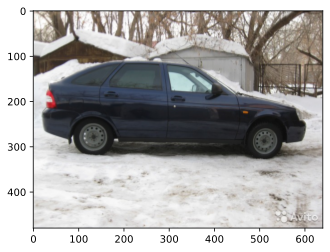

(640, 480)

In [21]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

### Подготовка данных

Аугментация данных

При недостаточном объёме датасета аугментация позволяет создать разнообразие для обучения используя одно изображение в разных представления, к примеру вращая его.

Будем использовать генератор данных ImageDataAugmentor, поддерживающий библиотеку albumentation.

In [22]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

In [23]:


AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

### Генерируем данные для обучения

In [24]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


## 3. Построение модели
#### Загрузим предобученную модель EfficientNetB7

In [25]:
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

258441216/258434480 [==============================] - 6s 0us/step


In [25]:
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

258441216/258434480 [==============================] - 6s 0us/step


In [26]:
base_model.summary()

Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
____________________________________________________________________________________

block7b_expand_conv (Conv2D)    (None, 7, 7, 3840)   2457600     block7a_project_bn[0][0]         
__________________________________________________________________________________________________
block7b_expand_bn (BatchNormali (None, 7, 7, 3840)   15360       block7b_expand_conv[0][0]        
__________________________________________________________________________________________________
block7b_expand_activation (Acti (None, 7, 7, 3840)   0           block7b_expand_bn[0][0]          
__________________________________________________________________________________________________
block7b_dwconv (DepthwiseConv2D (None, 7, 7, 3840)   34560       block7b_expand_activation[0][0]  
__________________________________________________________________________________________________
block7b_bn (BatchNormalization) (None, 7, 7, 3840)   15360       block7b_dwconv[0][0]             
__________________________________________________________________________________________________
block7b_ac

### На первом этапе замораживаем веса

In [27]:
# Для начала заморозим веса EfficientNetB7 и обучим только "голову". 
# Делаем это для того, чтобы хорошо обученные признаки на Imagenet не затирались в самом начале нашего обучения
base_model.trainable = False

In [28]:
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image

### Устанавливаем новую "голову" и добавляем слои

1. GlobalAveragePooling2D - слой пулинга представляет уплотнение карты признаков. В данном случае используем слой средней подвыборки для пространственных данных с параметрами "по умолчанию"

2. Dense - плотный слой нейронной сети с 256 нейронами и функцией активации Relu

3. BatchNormalization -слой нормализует активации предыдущего слоя. Поддерживает среднее в 0, а стандартное отклонение близко к 1.

4. Dropout - слой применяется для предотвращения переобучения сети, случайной установкой елиниц ввода в 0.

В последнем слое не используем функцию Relu, чтоб терять информацию на выходе, обрезая нули

In [29]:


model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),) # объединяем все признаки в единый вектор 

# Экспериментируем с архитектурой - добавляем ещё один полносвязный слой, dropout и batch-нормализацию

model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               655616    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 64,756,890
Trainable params: 658,698
Non-trainable params: 64,098,192
______________________________________

### Обучение модели

1. Функция call-back. К примеру можем использовать систему чекпоинтов, чтоб если в процессе обучения модель переобучается, то мы можем венуться к наилучшему результату.

2. earlystopping - останавливаемся, если модель не обучается более эпох = patience. Смотрит улучшение метрики в параметре monitor

In [31]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [32]:
# Обучаем

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = EPOCHS,
    callbacks = callbacks_list
    )

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
389/389 [==============================] - 201s 466ms/step - loss: 2.0374 - accuracy: 0.3339 - val_loss: 1.2085 - val_accuracy: 0.5693

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
389/389 [==============================] - 179s 460ms/step - loss: 1.5148 - accuracy: 0.4800 - val_loss: 1.0622 - val_accuracy: 0.6092

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
389/389 [==============================] - 177s 456ms/step - loss: 1.3973 - accuracy: 0.5073 - val_loss: 1.0027 - val_accuracy: 0.6521

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
389/389 [==============================] - 178s 457ms/step - loss: 1.3185 - accuracy: 0.5342 - val_loss: 0.9838 - val_accuracy: 0.6488

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
389/389 [==============================] - 177s 456ms/step - loss: 1.2542 - accuracy: 0.5652 - val_loss: 0.9302 - val_accuracy: 0.6733

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
389/389 [====================

In [33]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


98/98 [==============================] - 36s 361ms/step - loss: 0.8952 - accuracy: 0.6832
Accuracy: 68.32%


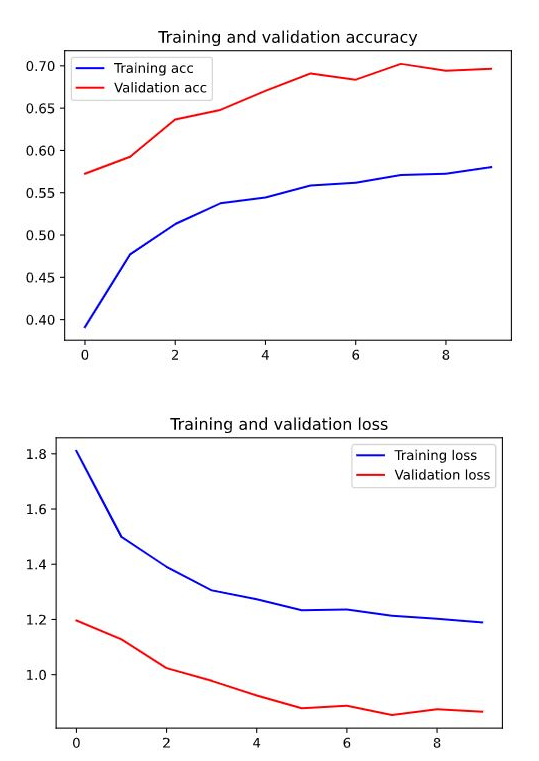

### Результат с предобученной сетью и замороженными весами  68.3%

In [35]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [36]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  806


### Fine Tuning - разморозим половину весов

In [37]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [38]:
len(base_model.trainable_variables)

354

In [39]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f4fc433a950> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f4fc4343d90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f4f67193890> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f4f6719d990> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f4f671f9dd0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f4f671a89d0> True


In [40]:
EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" # рабочая директория

# Устанавливаем конкретное значение random seed для воспроизводимости

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

# Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.    
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

# Обучаем

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = EPOCHS,
    callbacks = callbacks_list
    )

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Epoch 1/10
778/778 [==============================] - 272s 320ms/step - loss: 1.4115 - accuracy: 0.5199 - val_loss: 0.3922 - val_accuracy: 0.8576

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
778/778 [==============================] - 244s 313ms/step - loss: 0.6010 - accuracy: 0.7920 - val_loss: 0.2874 - val_accuracy: 0.8998

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
778/778 [==============================] - 245s 315ms/step - loss: 0.4125 - accuracy: 0.8496 - val_loss: 0.2296 - val_accuracy: 0.9198

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
778/778 [==============================] - 244s 314ms/step - loss: 0.3121 - accuracy: 0.8862 - val_loss: 0.2056 - val_accuracy: 0.9288

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
778/778 [==============================] - 244s 314ms/step - loss: 0.2516 - accuracy: 0.9114 - val_loss: 0.2057 - val_accuracy: 0.9301

In [41]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

195/195 [==============================] - 36s 182ms/step - loss: 0.1805 - accuracy: 0.9424
Accuracy: 94.24%


### Результат с предобученной сетью и половиной замороженных весов  94.2%

In [42]:
# Сохраним модель
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

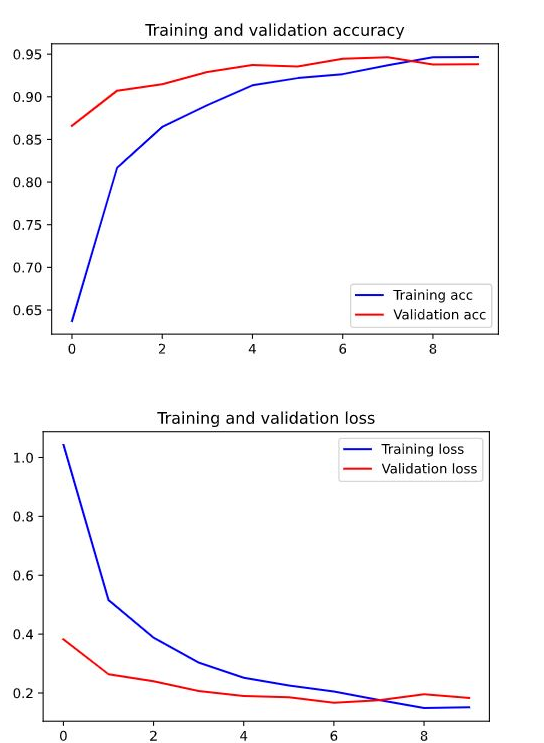

### FineTuning - разморозка всей сети EfficientNetB7 и дообучение

In [43]:
base_model.trainable = True

In [44]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-5
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" # рабочая директория

# Устанавливаем конкретное значение random seed для воспроизводимости

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

# Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.    
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

# Обучаем

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = EPOCHS,
    callbacks = callbacks_list
    )

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Epoch 1/8
1556/1556 [==============================] - 632s 387ms/step - loss: 0.2054 - accuracy: 0.9268 - val_loss: 0.1612 - val_accuracy: 0.9475

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
1556/1556 [==============================] - 600s 386ms/step - loss: 0.1863 - accuracy: 0.9350 - val_loss: 0.1542 - val_accuracy: 0.9533

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
1556/1556 [==============================] - 599s 385ms/step - loss: 0.1748 - accuracy: 0.9409 - val_loss: 0.1462 - val_accuracy: 0.9543

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
1556/1556 [==============================] - 599s 385ms/step - loss: 0.1578 - accuracy: 0.9481 - val_loss: 0.1525 - val_accuracy: 0.9559

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
1556/1556 [==============================] - 598s 384ms/step - loss: 0.1384 - accuracy: 0.9524 - val_loss: 0.1373 - val_accuracy: 0

In [45]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [46]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 38s 99ms/step - loss: 0.1430 - accuracy: 0.9585
Accuracy: 95.85%


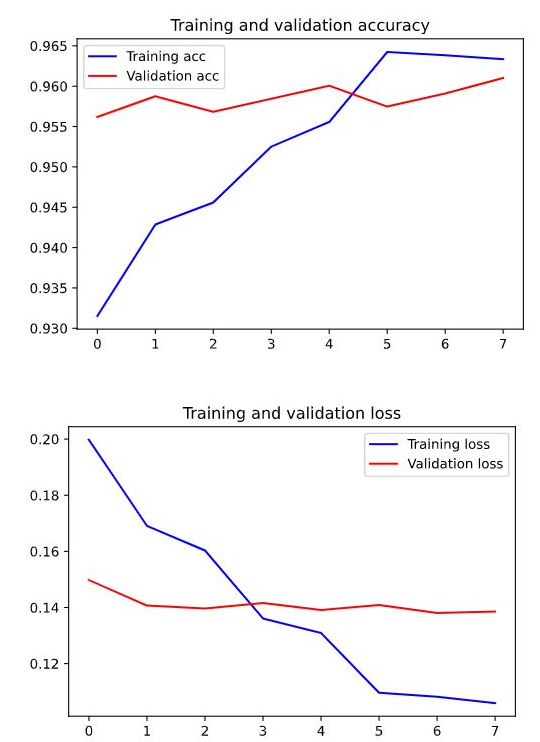

### Результат с предобученной сетью и  размороженными весами  95.8%

### Увеличим размер изображения и понизим уровень аугментации

In [47]:
IMG_SIZE             = 512
BATCH_SIZE           = 2
LR                   = 1e-5
EPOCHS               = 6  # эпох на обучение

input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

In [48]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


### Создадим сеть заново с новым размером входных данных

In [49]:
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

In [50]:
EPOCHS               = 4  # эпох на обучение
BATCH_SIZE           = 2 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-5

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

model.load_weights('best_model.hdf5') # Подгружаем ранее обученные веса

callbacks_list = [checkpoint, earlystop]

# Обучаем

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = EPOCHS,
    callbacks = callbacks_list
    )

Epoch 1/4
6226/6226 [==============================] - 3276s 522ms/step - loss: 1.1974 - accuracy: 0.7015 - val_loss: 0.1557 - val_accuracy: 0.9714

Epoch 00001: saving model to best_model.hdf5
Epoch 2/4
6226/6226 [==============================] - 3246s 521ms/step - loss: 0.7215 - accuracy: 0.8321 - val_loss: 0.1450 - val_accuracy: 0.9723

Epoch 00002: saving model to best_model.hdf5
Epoch 3/4
6226/6226 [==============================] - 3258s 523ms/step - loss: 0.6475 - accuracy: 0.8529 - val_loss: 0.1233 - val_accuracy: 0.9746

Epoch 00003: saving model to best_model.hdf5
Epoch 4/4
6226/6226 [==============================] - 3257s 523ms/step - loss: 0.5970 - accuracy: 0.8720 - val_loss: 0.1334 - val_accuracy: 0.9749

Epoch 00004: saving model to best_model.hdf5


In [51]:
model.save('../working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [52]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1555/1555 [==============================] - 148s 95ms/step - loss: 0.1251 - accuracy: 0.9768
Accuracy: 97.68%


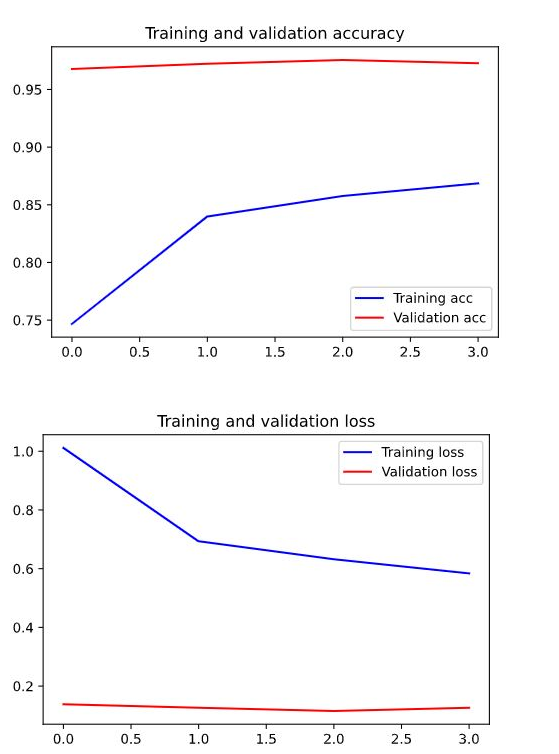

### Результат с предобученной сетью и увеличенным размером изображений  97.68%

## 4. Предсказание на тестовых данных

In [53]:
from sklearn.metrics import accuracy_score

In [54]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


In [55]:
test_sub_generator.samples

6675

In [56]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3338/3338 [==============================] - 307s 91ms/step


In [57]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [58]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


## 5. Выводы о результатах

1. Замороженные веса - результат 68.32% на базовой моделе EfficientNetB7.  
2. Половина весов размороженно - результат 94.24%. Кривые обучения и валидации показывают хороший результат, но дальнейшее обучение вряд ли имеет смысл.
3. Все веса размороженны - результат 95.85%. 
4. Увеличенный размер изображений - результат 97.68%. Согласно кривым обучения и валидации имеется тенденция к улучшению результата. 

Для дальнейшего улучшения результата имеет смысл менять основные параметры для последнего варианта эксперимента